In [8]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D,Flatten
from keras.optimizers import SGD, RMSprop
from keras.layers import MaxPool2D
import numpy
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
# Импорт датасета
batch_size = 32
image_size = 180
seed = 42

train=tf.keras.utils.image_dataset_from_directory("./input/train",
                                                  batch_size=batch_size,
                                                  image_size=(image_size, image_size),
                                                  seed=seed)
test=tf.keras.utils.image_dataset_from_directory("./input/test",
                                                 batch_size=batch_size,
                                                 image_size=(image_size, image_size),
                                                 seed=seed)
val=tf.keras.utils.image_dataset_from_directory("./input/valid",
                                                batch_size=batch_size,
                                                image_size=(image_size, image_size),
                                                seed=seed)
class_Names=train.class_names

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


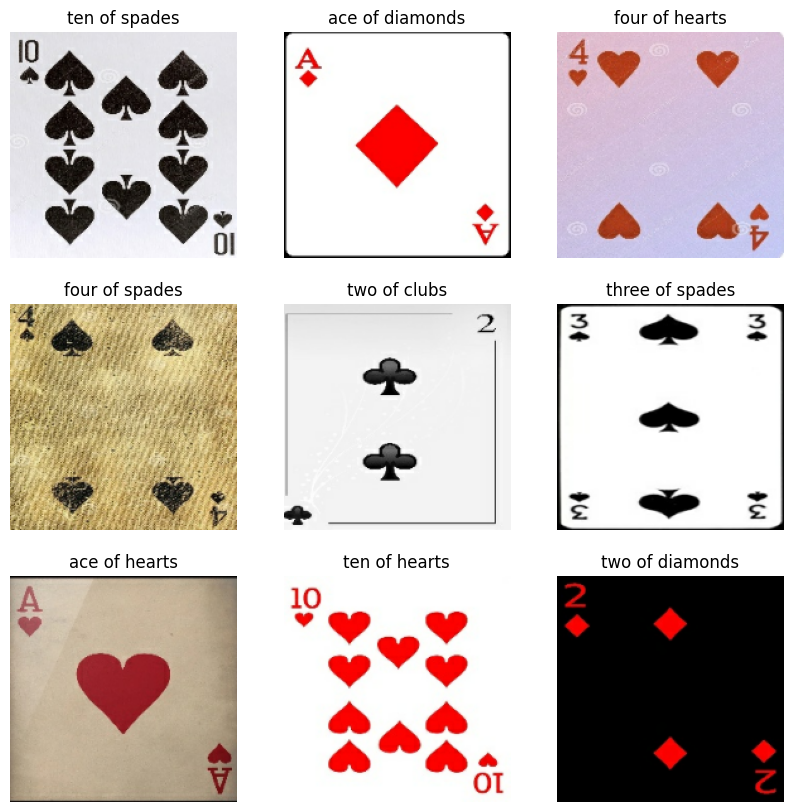

(32, 180, 180, 3)
(32,)


In [16]:
# Просмотр случайных изображений
plt.figure(figsize=(10,10))
for images, labels in test.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_Names[labels[i]])
        plt.axis("off")
plt.show()
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [12]:
# Оптимизация
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # кэширование данных;
                                                                   # перемешивание, чтобы НС не запоминала последовательность данных;
                                                                   # асинхронная буферизация следующего батча
val = val.cache().prefetch(buffer_size=AUTOTUNE) 
num_classes=len(class_Names)

In [13]:
# Топология сверточной нейронной сети
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)), # Изменение размеров изображения
    layers.Conv2D(16, 3, padding='same', activation='relu'), # Сверточный слой 
    layers.MaxPool2D(), # уменьшение размерности изображения и количества параметров в модели
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(.2), # обнуление случайным образом части входных элементов с вероятностью 0.2
    layers.Flatten(), 
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [14]:
# Параметры модели

epochs = 20

#optimizer = SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
#optimizer = RMSprop(learning_rate=0.001)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # используется в задачах классификации, где каждый образец принадлежит только одному классу

metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
# Обучение
history = model.fit(train, validation_data=val, epochs=epochs)

Epoch 1/20


KeyboardInterrupt: 